# COVID-19 

In this notebook we will go through the developments around the COVID-19 virus infections. First we look at the developments worldwide and finally EU only.

The dataset which I use in this project is provided by the [`European Centre for Disease Prevention and Control (ECDC)`](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases)

* Author: Erfan Nariman
* Date: 21-03-2020
* GitHub: [erfannariman](github.com/ErfPy)

# Table of contents
1. [Data import](#import)
2. [Data cleaning](#cleaning)
3. [Analysis](#analysis)  
    3.1 [Worldwide](#worldwide)  
    3.2 [Netherlands](#netherlands)  
    3.3 [Comparison Netherlands vs Italy](#nl_italy)  
    3.4 [China](#china)  
    3.5 [USA](#usa)

---

In [5]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from requests import HTTPError

from warnings import filterwarnings
filterwarnings('ignore')

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

---

# 1. Data import <a name='import'></a>

In [30]:
def import_data():
    """
    this scripts import the COVID-19 geographic distribution data from ECDC
    it also catches errors if you try to download data which is not uploaded yet
    in that case it will read the data from the day before
    """
    
    try:
        date = dt.datetime.today().strftime('%Y-%m-%d')
        df = pd.read_excel(f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{date}.xlsx')
    except HTTPError as e:
        print('File on ECDC not found, reading in data from day before')
        date = (dt.datetime.today() - dt.timedelta(days=1)).strftime('%Y-%m-%d')
        df = pd.read_excel(f'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{date}.xlsx')
        
    return df
        
df = import_data()
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,2020-04-05,5,4,2020,35,1,Afghanistan,AF,AFG,37172386.0
1,2020-04-04,4,4,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,2020-04-03,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
3,2020-04-02,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
4,2020-04-01,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0


# 2. Data cleaning <a name='cleaning'></a>

In [31]:
# clean up column names
df.columns = df.columns.str.replace('dateRep', 'Date').str.replace('countriesAndTerritories', 'Country').str.capitalize()

# convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# we filter out China to get rid of the extreme values
china = df.query('Country.eq("China")').copy()
df = df.query('Country.ne("China")').copy()

# replace name to Japan
df['Country'] = df['Country'].str.replace('Cases on an international conveyance Japan', 'Japan')

# print first 5 rows of dataframe
df.head()

,Date,Day,Month,Year,Cases,Deaths,Country,Geoid,Countryterritorycode,Popdata2018
0,2020-04-05,5,4,2020,35,1,Afghanistan,AF,AFG,37172386.0
1,2020-04-04,4,4,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,2020-04-03,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
3,2020-04-02,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
4,2020-04-01,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0


---

# 3.Analysis <a name='analysis'></a>

### 3.1 Worldwide <a name='worldwide'></a>
Minus China, to get rid of the extreme values for our model later on.
China is analyzed further on in this notebook

In [32]:
# range of data in days
df['Date'].max() - df['Date'].min()

Timedelta('96 days 00:00:00')

In [33]:
# checking for missing days by resampling and checking for NaN
df.set_index('Date').resample('D').mean().isna().sum()

Day            0
Month          0
Year           0
Cases          0
Deaths         0
Popdata2018    0
dtype: int64

In [34]:
def plot(data, kind, ylabel, xlabel, title, path_savefig):
    """
    functions to plot the aggregated data
    """
    
    data.plot(kind=kind, figsize=(15,9))
    plt.xticks(size=12)
    plt.ylabel(ylabel, size=14)
    plt.xlabel(xlabel, size=14)
    plt.title(title, size=15)
    plt.tight_layout()
    plt.savefig(path_savefig, dpi=100)
    plt.show()

### Which countries had highest new confirmed cases on a day

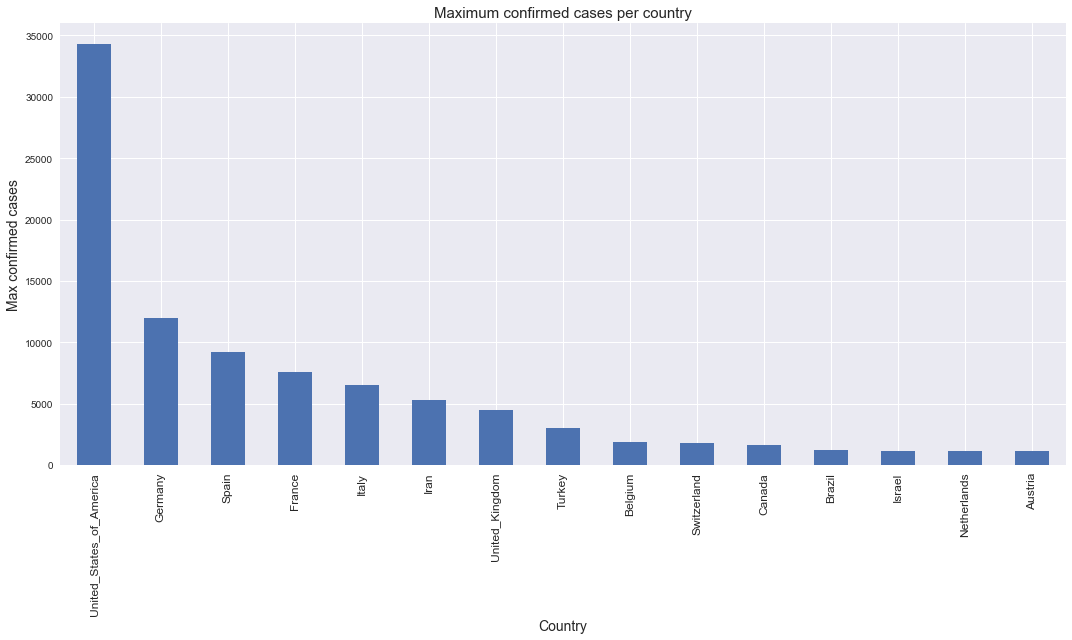

In [35]:
data = df.groupby('Country')['Cases'].max().sort_values(ascending=False).head(15)
plot(data, 'bar', 'Max confirmed cases', 'Country', 'Maximum confirmed cases per country', '../plots/plt1.png')

### Countries with highest total confirmed cases

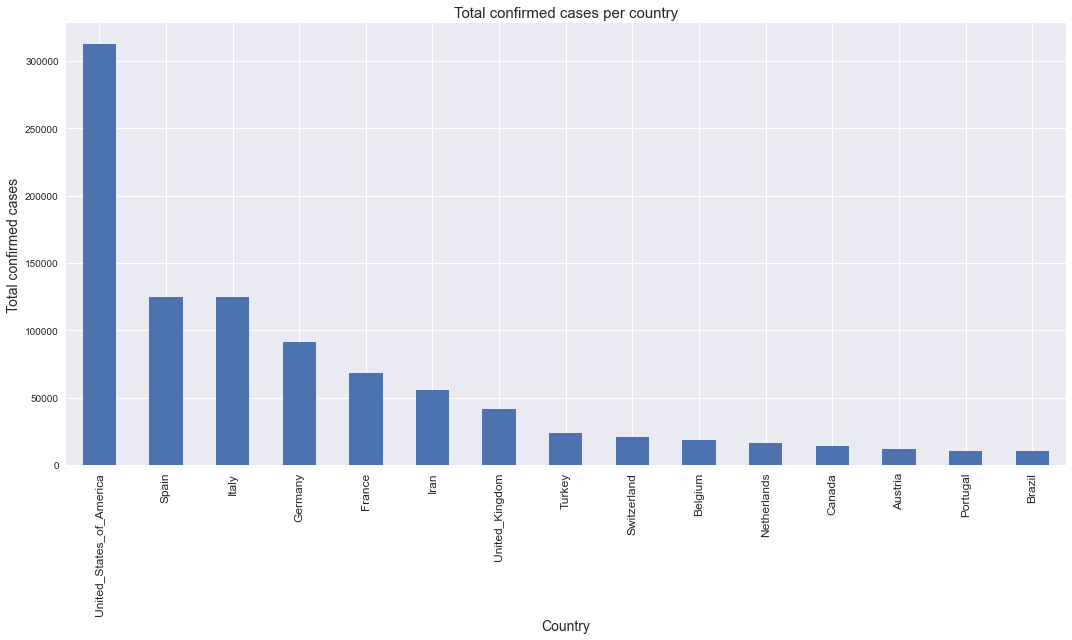

In [36]:
data = df.groupby('Country')['Cases'].sum().sort_values(ascending=False).head(15)
plot(data, 'bar', 'Total confirmed cases', 'Country', 'Total confirmed cases per country', '../plots/plt2.png')

### Top 15 total deaths per country

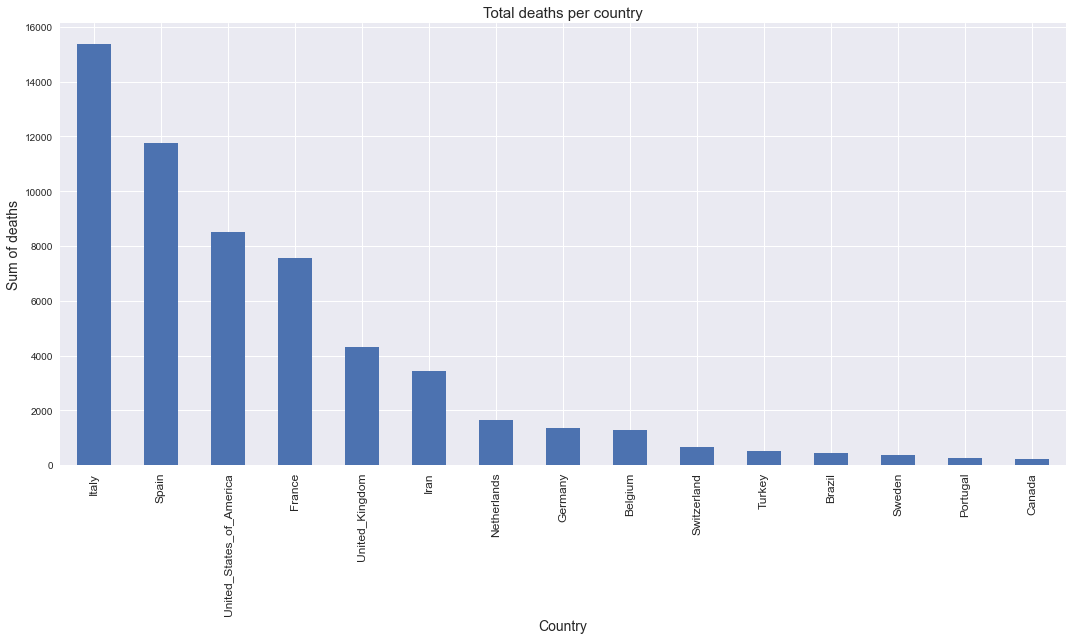

In [37]:
data = df.groupby('Country')['Deaths'].sum().sort_values(ascending=False).head(15)
plot(data, 'bar', 'Sum of deaths', 'Country', 'Total deaths per country', '../plots/plt3.png')

### Cumulative sum of confirmed cases over time

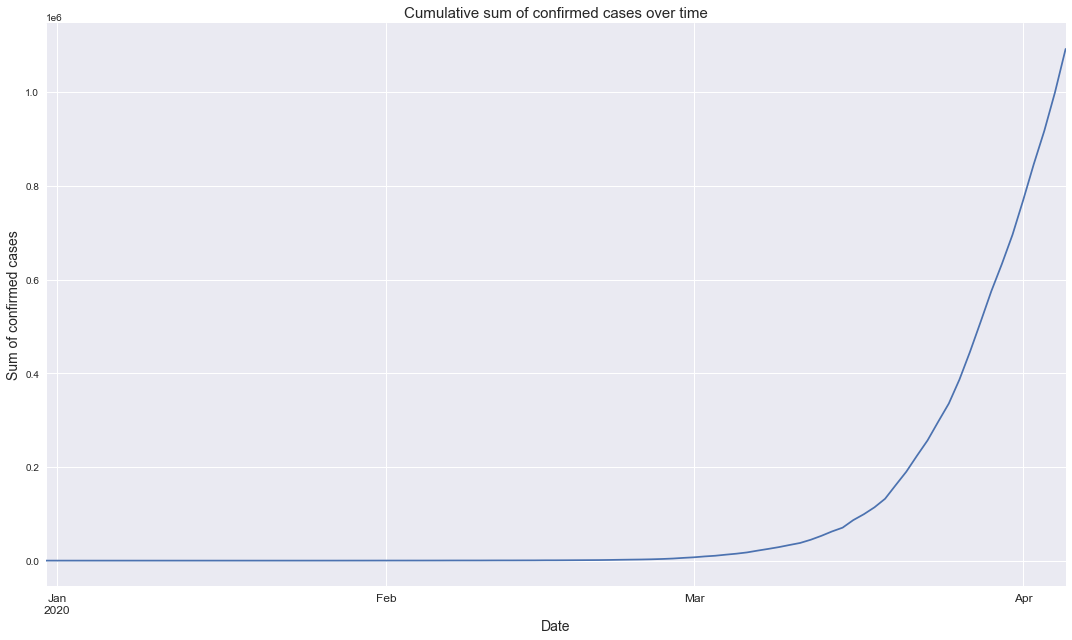

In [38]:
cases_cumsum = df.groupby('Date')['Cases'].sum().cumsum()
plot(cases_cumsum, 'line', 'Sum of confirmed cases', 'Date', 'Cumulative sum of confirmed cases over time', '../plots/plt4.png')

### The log of cumulative sum to check if growth is actually exponential

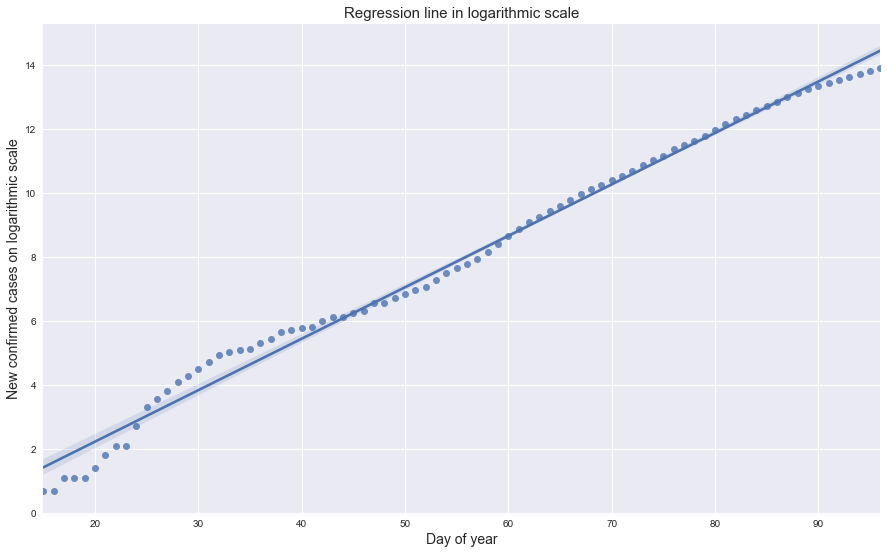

In [39]:
log_cumsum = np.log(cases_cumsum[cases_cumsum.gt(1)]).to_frame().reset_index()
log_cumsum['Date'] = log_cumsum['Date'].dt.dayofyear

plt.figure(figsize=(15,9))
plt.title("Regression line in logarithmic scale", size=15)
sns.regplot(x='Date', y='Cases', data=log_cumsum)
plt.xlabel('Day of year', size=14)
plt.ylabel('New confirmed cases on logarithmic scale', size=14)
plt.savefig('../plots/plt5.png')
plt.show()

### Fit a regression line through the log of confirmed cases, this way we can check R^2 

In [40]:
X = log_cumsum['Date']
y = log_cumsum['Cases']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Cases   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          2.117e+04
Date:                Sun, 05 Apr 2020   Prob (F-statistic):                   9.54e-100
Time:                        14:42:51   Log-Likelihood:                         -66.465
No. Observations:                  82   AIC:                                      134.9
Df Residuals:                      81   BIC:                                      137.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date           0.1458      0.001    145.509      0.000       0.144       0.148
==============================================================================
Omnibus:                       28.322   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.903
Skew:                          -1.553   Prob(JB):                     7.96e-10
Kurtosis:                       4.617   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Growth proportion per day, > 1 means we are still in an exponential growth

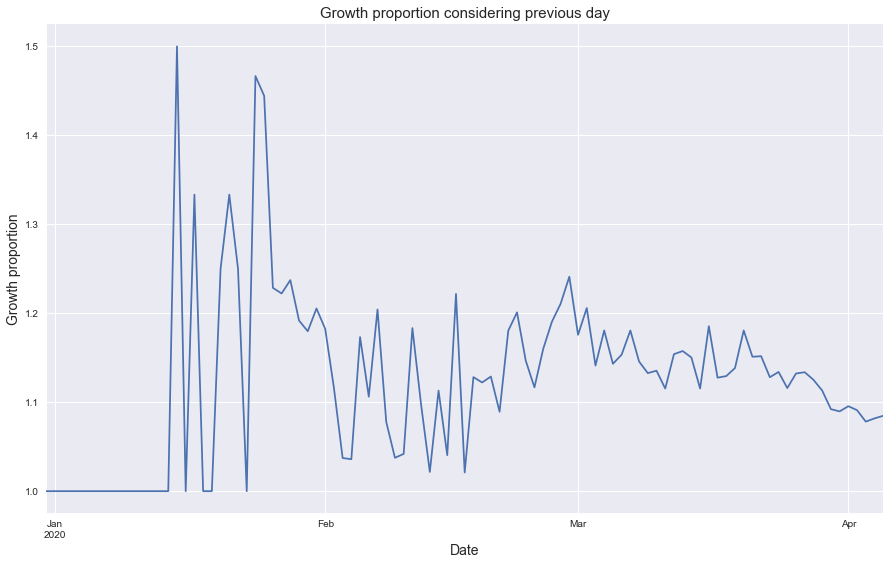

In [41]:
cases_cumsum = cases_cumsum.replace(0, 1)
cases_cumsum.diff().div(cases_cumsum).add(1).fillna(1).plot(figsize=(15,9))

plt.title('Growth proportion considering previous day', size=15)
plt.xlabel('Date', size=14)
plt.ylabel('Growth proportion', size=14)
plt.savefig('../plots/plt6.png')
plt.show()

### Time series analysis

In [42]:
from itertools import product

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

In [43]:
y = cases_cumsum
y.index = pd.DatetimeIndex(y.index.values,
                           freq=y.index.inferred_freq)

results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            results_list.append((param, param_seasonal, results.aic))
        except:
            continue

In [44]:
min_aic = min([aic for x, y, aic in results_list if aic > 0])
for param, p_seasonal, aic in results_list:
    if aic == min_aic:
        p, p_s, a = param, p_seasonal, aic

print(p, p_s, a)

(1, 1, 1) (0, 1, 1, 12) 1333.8963378491414


In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=p,
                                seasonal_order=p_s,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0604      0.008    136.729      0.000       1.045       1.076
ma.L1         -0.2076      0.092     -2.245      0.025      -0.389      -0.026
ma.S.L12      -0.6041      0.198     -3.056      0.002      -0.992      -0.217
sigma2      9.542e+06   1.33e-08   7.17e+14      0.000    9.54e+06    9.54e+06


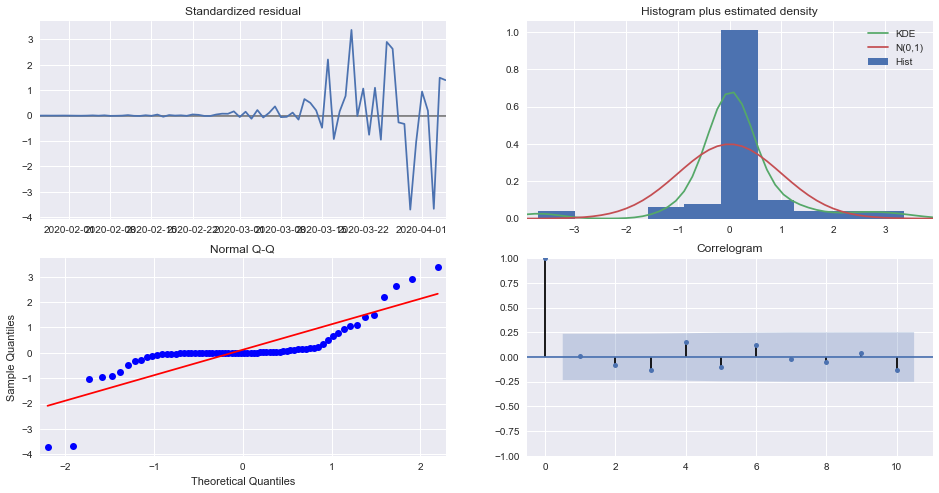

In [46]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('../plots/plt7.png')
plt.show()

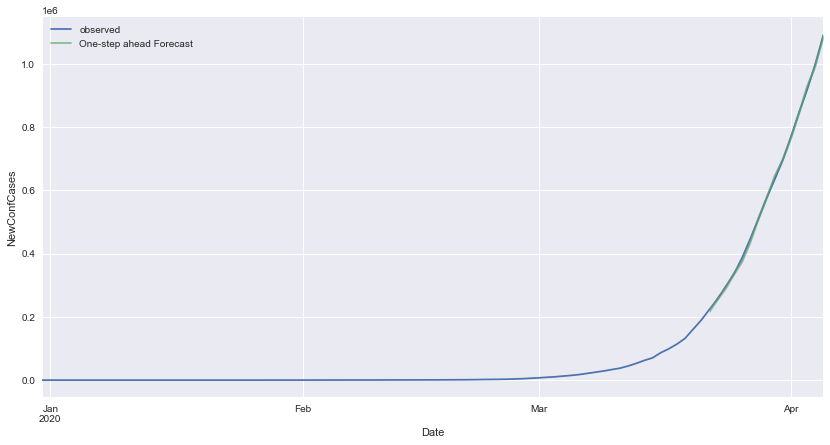

In [47]:
pred = results.get_prediction(start=(y.index.max() - pd.Timedelta(days=14)), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.savefig('../plots/plt8.png')
plt.show()

In [48]:
y_forecasted = pred.predicted_mean
y_truth = y[(y.index.max() - pd.Timedelta(days=14)):]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 33554358.84


In [49]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of our forecasts is 5792.61


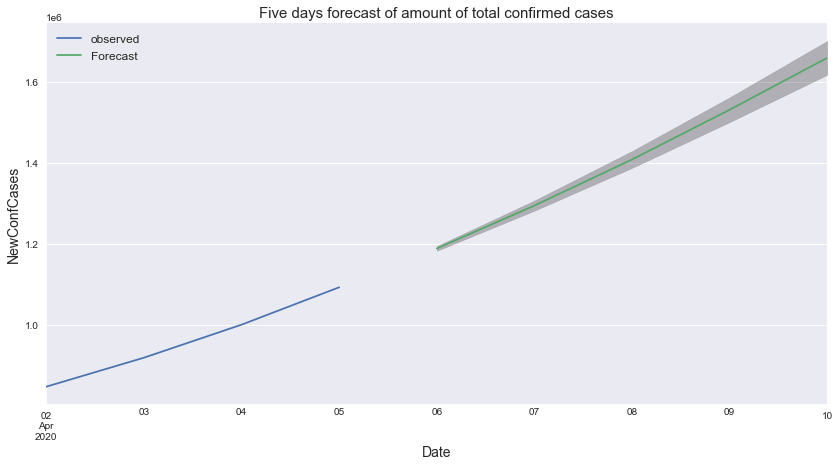

In [50]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y[(y.index.max() - pd.Timedelta(days=3)):].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('NewConfCases', size=14)
plt.legend(fontsize=12)
plt.title('Five days forecast of amount of total confirmed cases', size=15)
plt.savefig('../plots/plt9.png')
plt.show()

### 3.2 Netherlands <a name='netherlands'></a>

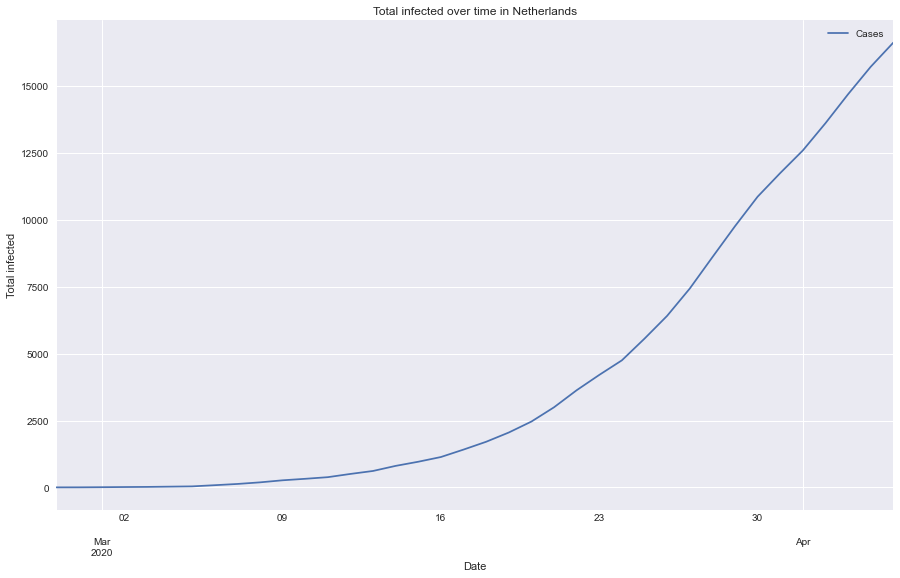

In [51]:
df.query('Country == "Netherlands" & Cases > 0').loc[:, ['Date', 'Cases']].set_index('Date').sort_index().cumsum().plot(figsize=(15,9))
plt.ylabel('Total infected')
plt.title('Total infected over time in Netherlands')
plt.savefig('../plots/NL1.png')
plt.show()

### Amount of confirmed cases per city

In [52]:
per_city = pd.read_csv(os.path.join('..', 'data', 'cases_per_municipality.csv'), sep=';')
per_city['Aantal per 100.000 inwoners'] = per_city['Aantal per 100.000 inwoners'].str.replace(',', '.').astype(float)
per_city.head()

,Category,Aantal per 100.000 inwoners,Aantal
0,'s-Gravenhage,8.7,47
1,'s-Hertogenbosch,35.7,55
2,Aa en Hunze,3.9,1
3,Aalsmeer,22.1,7
4,Aalten,3.7,1


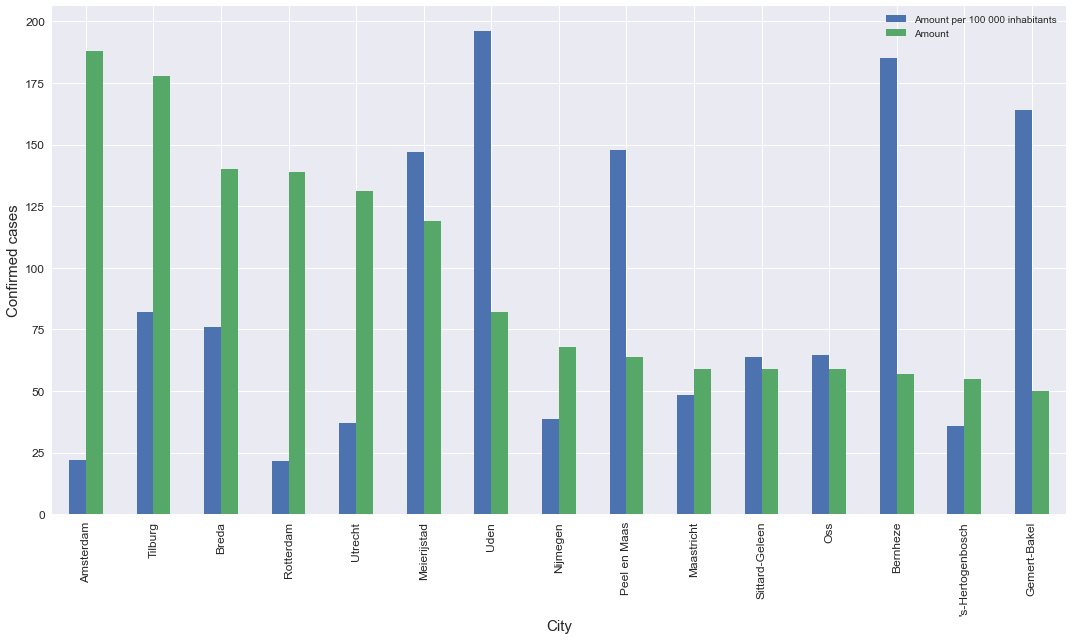

In [53]:
per_city.sort_values('Aantal', ascending=False).head(15).plot(kind='bar', figsize=(15,9), x='Category')
plt.xlabel('City', size=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Confirmed cases', size=15)
plt.legend(['Amount per 100 000 inhabitants', 'Amount'])
plt.tight_layout()
plt.savefig('../plots/NL2.png')
plt.show()

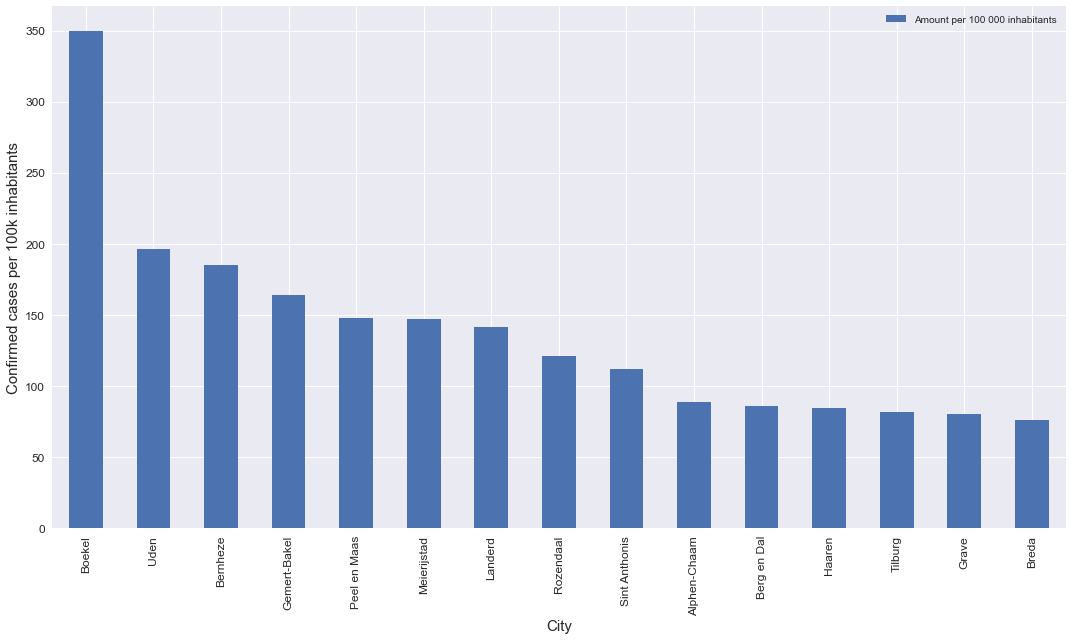

In [54]:
per_city.sort_values('Aantal per 100.000 inwoners', ascending=False).head(15).plot(kind='bar', figsize=(15,9), x='Category', y='Aantal per 100.000 inwoners')
plt.xlabel('City', size=15)
plt.xticks(size=12)
plt.ylabel('Confirmed cases per 100k inhabitants', size=15)
plt.yticks(size=12)
plt.legend(['Amount per 100 000 inhabitants', 'Amount'])
plt.tight_layout()
plt.savefig('../plots/NL3.png')
plt.show()

In [55]:
provincies_lat_lon = pd.read_csv('https://raw.githubusercontent.com/bobdenotter/4pp/master/4pp.csv')
provincies_lat_lon['gemeente'] = provincies_lat_lon['gemeente'].str.replace('Den Haag', "'s-Gravenhage")
provincies_lat_lon = provincies_lat_lon[['gemeente', 'latitude', 'longitude']].groupby('gemeente').mean()
provincies_lat_lon.head()

,latitude,longitude
gemeente,,
's-Gravenhage,52.071831,4.302761
's-Hertogenbosch,51.707012,5.329738
Aa en Hunze,53.003097,6.712131
Aalburg,51.739025,5.074134
Aalsmeer,52.258958,4.757882


In [56]:
per_city = per_city.set_index('Category').join(provincies_lat_lon).dropna().reset_index()
per_city['Aantal_normalized'] = (per_city['Aantal'] - per_city['Aantal'].min()) / (per_city['Aantal'].max() - per_city['Aantal'].min()) * 10
per_city['Aantal_normalized'] = per_city['Aantal_normalized'].replace(0, 0.01)

In [58]:
import folium

m = folium.Map(
    location=[51.91, 4.445],
    zoom_start=9,
)

per_city.apply(lambda row:folium.CircleMarker(location=[row["latitude"], 
                                              row["longitude"]],
                                              radius=row['Aantal_normalized'],
                                              fill=True,
                                              fill_opacity=0.5,
                                              tooltip=row['Category']
                                             ).add_to(m),axis=1)

0      <folium.vector_layers.CircleMarker object at 0...
1      <folium.vector_layers.CircleMarker object at 0...
2      <folium.vector_layers.CircleMarker object at 0...
3      <folium.vector_layers.CircleMarker object at 0...
4      <folium.vector_layers.CircleMarker object at 0...
                             ...                        
323    <folium.vector_layers.CircleMarker object at 0...
324    <folium.vector_layers.CircleMarker object at 0...
325    <folium.vector_layers.CircleMarker object at 0...
326    <folium.vector_layers.CircleMarker object at 0...
327    <folium.vector_layers.CircleMarker object at 0...
Length: 328, dtype: object

In [59]:
m

### 3.3 Comparison Netherlands vs Italy <a name='nl_italy'></a>

In [61]:
df.head()

,Date,Day,Month,Year,Cases,Deaths,Country,Geoid,Countryterritorycode,Popdata2018
0,2020-04-05,5,4,2020,35,1,Afghanistan,AF,AFG,37172386.0
1,2020-04-04,4,4,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,2020-04-03,3,4,2020,43,0,Afghanistan,AF,AFG,37172386.0
3,2020-04-02,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
4,2020-04-01,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0


In [62]:
italy = df[df['Country'].eq('Italy') & df['Cases'].gt(0)].sort_values('Date').reset_index(drop=True).drop(columns=['Day', 'Month', 'Year', 'Geoid', 'Countryterritorycode', 'Popdata2018']).add_suffix('_Italy')
nl = df[df['Country'].eq('Netherlands') & df['Cases'].gt(0)].sort_values('Date').reset_index(drop=True).drop(columns=['Day', 'Month', 'Year', 'Geoid', 'Countryterritorycode', 'Popdata2018']).add_suffix('_NL')

nl_italy = pd.concat([italy, nl], axis=1)

nl_italy.head()

,Date_Italy,Cases_Italy,Deaths_Italy,Country_Italy,Date_NL,Cases_NL,Deaths_NL,Country_NL
0,2020-01-31,3,0,Italy,2020-02-28,1.0,0.0,Netherlands
1,2020-02-22,14,0,Italy,2020-02-29,1.0,0.0,Netherlands
2,2020-02-23,62,2,Italy,2020-03-01,5.0,0.0,Netherlands
3,2020-02-24,53,0,Italy,2020-03-02,6.0,0.0,Netherlands
4,2020-02-25,97,4,Italy,2020-03-03,5.0,0.0,Netherlands


In [63]:
nl_italy['Cases_NL_cumsum'] = nl_italy['Cases_NL'].cumsum()
nl_italy['Cases_Italy_cumsum'] = nl_italy['Cases_Italy'].cumsum()

nl_italy

,Date_Italy,Cases_Italy,Deaths_Italy,Country_Italy,Date_NL,Cases_NL,Deaths_NL,Country_NL,Cases_NL_cumsum,Cases_Italy_cumsum
0,2020-01-31,3,0,Italy,2020-02-28,1.0,0.0,Netherlands,1.0,3
1,2020-02-22,14,0,Italy,2020-02-29,1.0,0.0,Netherlands,2.0,17
2,2020-02-23,62,2,Italy,2020-03-01,5.0,0.0,Netherlands,7.0,79
3,2020-02-24,53,0,Italy,2020-03-02,6.0,0.0,Netherlands,13.0,132
4,2020-02-25,97,4,Italy,2020-03-03,5.0,0.0,Netherlands,18.0,229
5,2020-02-26,93,5,Italy,2020-03-04,10.0,0.0,Netherlands,28.0,322
6,2020-02-27,78,1,Italy,2020-03-05,10.0,0.0,Netherlands,38.0,400
7,2020-02-28,250,5,Italy,2020-03-06,44.0,0.0,Netherlands,82.0,650
8,2020-02-29,238,4,Italy,2020-03-07,46.0,1.0,Netherlands,128.0,888
9,2020-03-01,240,8,Italy,2020-03-08,60.0,0.0,Netherlands,188.0,1128


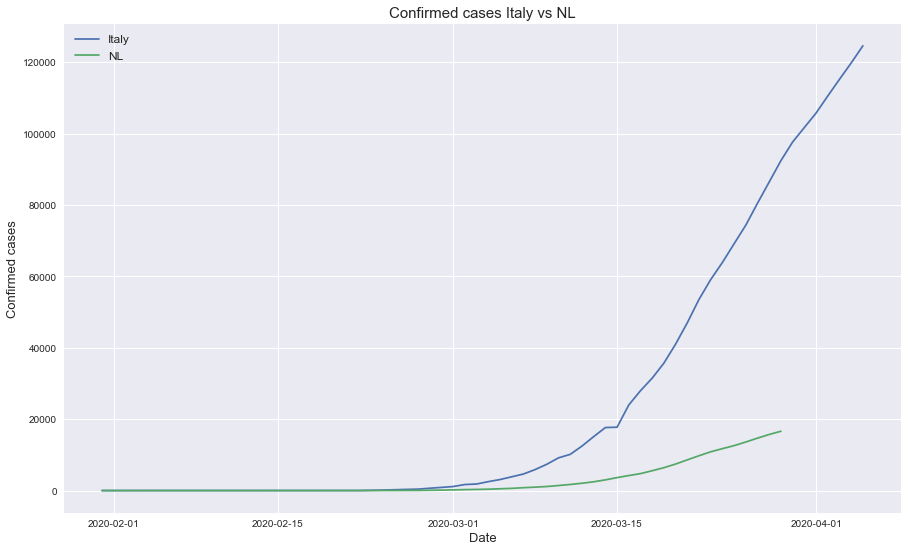

In [64]:
plt.figure(figsize=(15,9))
plt.title('Confirmed cases Italy vs NL', size=15)
plt.plot(nl_italy['Date_Italy'], nl_italy['Cases_Italy_cumsum'], label='Italy')
plt.plot(nl_italy['Date_Italy'], nl_italy['Cases_NL_cumsum'], label='NL')
plt.ylabel('Confirmed cases', size=13)
plt.xlabel('Date', size=13)
plt.legend(fontsize=12)
plt.savefig('../plots/nl_italy1.png')

### 3.4 China <a name='china'></a>

In [65]:
china = china.set_index('Date').sort_index()
china.sort_index(ascending=False)

,Day,Month,Year,Cases,Deaths,Country,Geoid,Countryterritorycode,Popdata2018
Date,,,,,,,,,
2020-04-05,5,4,2020,48,3,China,CN,CHN,1.392730e+09
2020-04-04,4,4,2020,62,4,China,CN,CHN,1.392730e+09
2020-04-03,3,4,2020,70,10,China,CN,CHN,1.392730e+09
2020-04-02,2,4,2020,100,6,China,CN,CHN,1.392730e+09
2020-04-01,1,4,2020,54,1,China,CN,CHN,1.392730e+09
...,...,...,...,...,...,...,...,...,...
2020-01-04,4,1,2020,0,0,China,CN,CHN,1.392730e+09
2020-01-03,3,1,2020,17,0,China,CN,CHN,1.392730e+09
2020-01-02,2,1,2020,0,0,China,CN,CHN,1.392730e+09


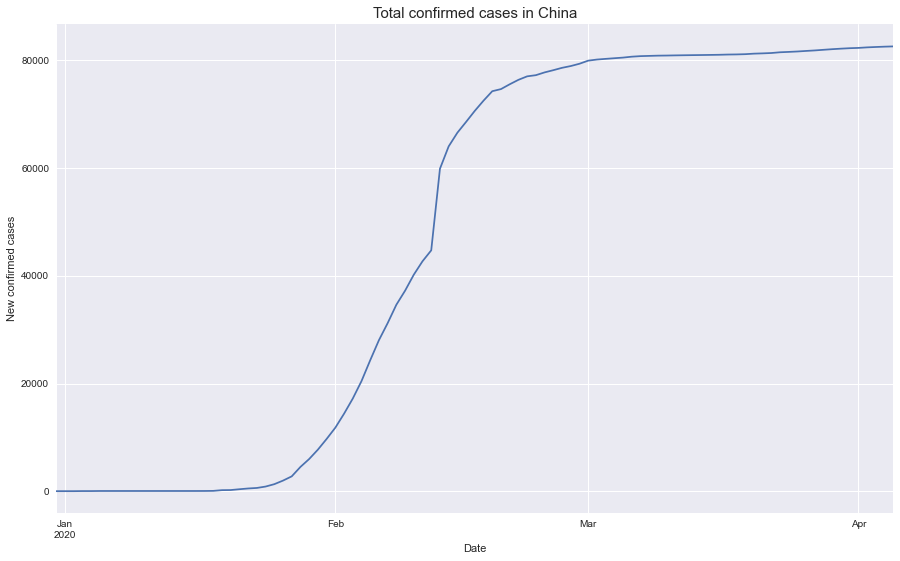

In [66]:
china['Cases'].cumsum().plot(figsize=(15,9))
plt.ylabel('New confirmed cases')
plt.title('Total confirmed cases in China', size=15)
plt.savefig('../plots/china1.png')
plt.show()

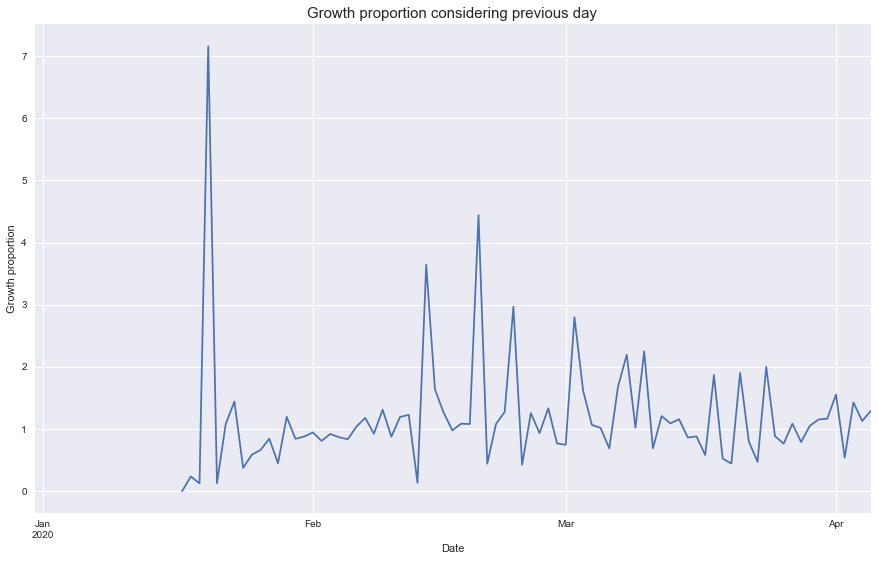

In [67]:
china['Cases'].shift().div(china['Cases']).plot(figsize=(15,9))
plt.ylabel('Growth proportion')
plt.title('Growth proportion considering previous day', size=15)
plt.savefig('../plots/china1.png')
plt.show()

### 3.5 USA <a name='usa'></a>

In [68]:
usa = df.query('Country == "United_States_of_America"').reset_index(drop=True)
usa.head()

,Date,Day,Month,Year,Cases,Deaths,Country,Geoid,Countryterritorycode,Popdata2018
0,2020-04-05,5,4,2020,34272,1344,United_States_of_America,US,USA,327167434.0
1,2020-04-04,4,4,2020,32425,1104,United_States_of_America,US,USA,327167434.0
2,2020-04-03,3,4,2020,28819,915,United_States_of_America,US,USA,327167434.0
3,2020-04-02,2,4,2020,27103,1059,United_States_of_America,US,USA,327167434.0
4,2020-04-01,1,4,2020,24998,909,United_States_of_America,US,USA,327167434.0


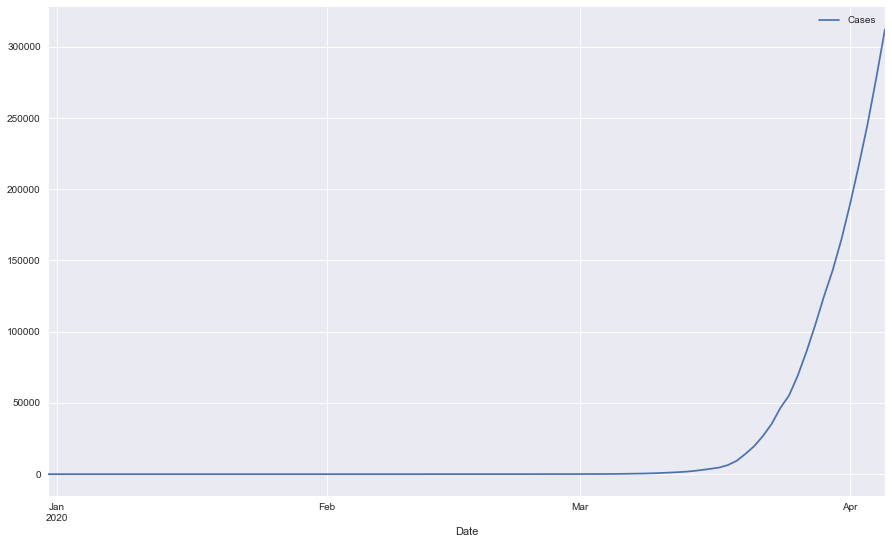

In [69]:
usa[['Date', 'Cases']].set_index('Date').sort_index().cumsum().plot(figsize=(15,9))

In [70]:
df = pd.read_csv('https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv')

HTTPError: HTTP Error 403: FORBIDDEN

In [54]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183


In [55]:
df['Total'] = df.filter(regex='\d+/\d+/\d+').max(axis=1)
df['Total_log'] = np.log(df['Total'])
df['Province/State'] = df['Province/State'].fillna(df['Country/Region'])

In [56]:
usa = df[df['Country/Region'].eq('US')].reset_index(drop=True)

In [57]:
usa.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,Total,Total_log
0,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014,1376,1524,1793,1793,7.491645
1,New York,US,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495,5365,8310,11710,11710,9.368198
2,California,US,36.1162,-119.6816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751,952,1177,1364,1364,7.218177
3,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218,328,413,525,525,6.263398
4,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,49,49,49,3.891820


In [58]:
import folium

In [59]:
m = folium.Map(
    location=[47.4009, -74.5],
    zoom_start=3,
    tiles='Stamen Terrain'
)

df.apply(lambda row:folium.CircleMarker(location=[row["Lat"], 
                                                  row["Long"]],
                                        radius=row['Total_log'],
                                        fill=True,
                                        fill_opacity=0.5,
                                        tooltip=row['Province/State']
                                       ).add_to(m),axis=1)

0      <folium.vector_layers.CircleMarker object at 0...
1      <folium.vector_layers.CircleMarker object at 0...
2      <folium.vector_layers.CircleMarker object at 0...
3      <folium.vector_layers.CircleMarker object at 0...
4      <folium.vector_layers.CircleMarker object at 0...
                             ...                        
477    <folium.vector_layers.CircleMarker object at 0...
478    <folium.vector_layers.CircleMarker object at 0...
479    <folium.vector_layers.CircleMarker object at 0...
480    <folium.vector_layers.CircleMarker object at 0...
481    <folium.vector_layers.CircleMarker object at 0...
Length: 482, dtype: object

In [60]:
m

---